<a href="https://colab.research.google.com/github/mathaiml5/cpsc5710-trustworthyDL-finalproject/blob/main/patch_attack_defenses_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer Robustness for Patch Based Adversarial Attacks & Defenses

We implement a robustness evaluation pipeline for Vision Transformers (ViT, DeiT, DINOv2) using the "ILSVRC/imagenet-1k" dataset. The main steps ares:
1.  **Setup**: Authenticate with Hugging Face, install dependencies, and load models with ImageNet-1k label mappings.
2.  **Baseline Generation**: Stream the validation split dataset to select `MAX_SAMPLES` images that are correctly classified by the target models (Clean Baseline).
3.  **Adversarial Experimentation**: For each baseline image, generate adversarial variants using patch attacks (Token, Patch-Perturbation, Patch-Fool) and apply input defenses (Blur, Compression, Patch Masking). Iterate through the baseline images to generate a detailed dataset of adversarial and defended variants, performing inference to capture predictions and probabilities.
4.  **Metric Calculation**: Compute aggregate metrics for Accuracy and Attack Success Rate (ASR) based on the model's predictions to evaluate defense effectiveness
5.  **Publishing Results**: Save the detailed results (images, labels, predictions) and an aggregate summary table as datasets to the Hugging Face Hub.


## Install & Setup




In [1]:
# 1. Install required libraries
!pip install transformers datasets accelerate torchmetrics huggingface_hub scikit-learn --quiet

# 2. Authenticate with Hugging Face
from huggingface_hub import login
from google.colab import userdata
import os
import torch
import numpy as np
import pandas as pd

try:
    # Attempt to retrieve token from Colab secrets
    hf_token = userdata.get('hf-key')
    if hf_token:
        login(token=hf_token, add_to_git_credential=True)
        print("Logged in using 'hf-key' from Colab secrets.")
    else:
        raise ValueError("Token is empty")
except Exception:
    print("Could not retrieve 'hf-key' from secrets. Initiating interactive login...")
    login(add_to_git_credential=True)

# 2b. for Yale Research clusters
#  load_dotenv()
#  hf_token = os.getenv("HF_TOKEN")


# 3. Determine computation device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 14.6 MB/s eta 0:00:00
Logged in using 'hf-key' from Colab secrets.
Using device: cuda


## Model Zoo & Label Mapping


Load target models (ViT, DeiT, DINOv2) and retrieve the ImageNet label mapping.


In [2]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

# 1. Define model checkpoints
MODEL_CHECKPOINTS = {
    "vit": "google/vit-base-patch16-224",
    "deit": "facebook/deit-base-distilled-patch16-224",
    "dinov2": "facebook/dinov2-small-imagenet1k-1-layer"
}

# 2. Load models and image processors
models = {}
processors = {}

print("Loading models...")
for key, checkpoint in MODEL_CHECKPOINTS.items():
    try:
        print(f" -> Loading {key} from {checkpoint}...")
        # use_fast=True suppresses the slow processor warning
        processor = AutoImageProcessor.from_pretrained(checkpoint, use_fast=True)
        model = AutoModelForImageClassification.from_pretrained(checkpoint)
        model.to(device)
        model.eval()

        models[key] = model
        processors[key] = processor
    except Exception as e:
        print(f"Failed to load {key}: {e}")

# 3. Retrieve label mappings (using ViT as reference)
if "vit" in models:
    id2label = models["vit"].config.id2label
    num_classes = len(id2label)
    print(f"\nSuccessfully loaded {len(models)} models.")
    print(f"Label mapping retrieved with {num_classes} classes.")
else:
    print("\nWarning: ViT model not loaded, could not retrieve label mapping.")

Loading models...
 -> Loading vit from google/vit-base-patch16-224...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

 -> Loading deit from facebook/deit-base-distilled-patch16-224...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

 -> Loading dinov2 from facebook/dinov2-small-imagenet1k-1-layer...


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/91.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]


Successfully loaded 3 models.
Label mapping retrieved with 1000 classes.


## Attacks & Defenses Implementation



### Patch Based Attacks

#### Token-Attack (Joshi et al. 2021)
Token-Attack perturbs a small number of tokens (patches) while others remain untouched, implemented as a block-sparse adversarial perturbation.

#### Patch-Perturbation (similar to Gu et al. 2021)
Patch-Perturbation perturbs one or more patches to maximize model loss, analyzing robustness to patch-wise adversarial perturbations.

#### Patch-Fool (Fu et al. 2022)
Patch-Fool is an attention-aware patch attack selecting the most influential patch via attention scores.​

Here we use a simplified version: choose the patch that maximizes loss gradient norm, then restrict updates to that patch.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
from dataclasses import dataclass
from typing import Tuple, List, Dict, Callable

# --- 1. Configuration & Helpers ---

@dataclass
class PatchAttackConfig:
    name: str
    patch_ratio: float = 0.02
    num_steps: int = 40
    step_size: float = 0.01
    targeted: bool = False

def get_num_patch_pixels(img_h: int, img_w: int, patch_ratio: float) -> Tuple[int, int]:
    area = img_h * img_w
    patch_area = int(area * patch_ratio)
    side = int(math.sqrt(patch_area))
    side = max(8, side)
    return side, side

def random_patch_box(img_h: int, img_w: int, patch_h: int, patch_w: int) -> Tuple[int, int, int, int]:
    top = random.randint(0, img_h - patch_h)
    left = random.randint(0, img_w - patch_w)
    return top, left, top + patch_h, left + patch_w

def get_hf_norm_stats(processor, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Retrieves normalization mean and std from the processor and returns them as tensors
    reshaped for broadcasting (1, C, 1, 1).
    """
    # Default to ImageNet stats if not found
    mean = getattr(processor, "image_mean", [0.485, 0.456, 0.406])
    std = getattr(processor, "image_std", [0.229, 0.224, 0.225])

    if mean is None: mean = [0.0, 0.0, 0.0]
    if std is None: std = [1.0, 1.0, 1.0]

    mean_tensor = torch.tensor(mean, device=device).view(1, 3, 1, 1)
    std_tensor = torch.tensor(std, device=device).view(1, 3, 1, 1)
    return mean_tensor, std_tensor

def clamp_to_valid_range(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """
    Clamps the normalized tensor 'x' so that it corresponds to [0, 1] in the original pixel space.
    """
    min_val = (0.0 - mean) / std
    max_val = (1.0 - mean) / std
    return x.clamp(min=min_val, max=max_val)

# --- 2. Attack Implementations ---

def token_attack_hf(model, pixel_values, labels, config, processor):
    """Perturbs a specific patch region to maximize loss."""
    model.eval()
    n, c, h, w = pixel_values.shape
    mean, std = get_hf_norm_stats(processor, pixel_values.device)
    patch_h, patch_w = get_num_patch_pixels(h, w, config.patch_ratio)
    boxes = [random_patch_box(h, w, patch_h, patch_w) for _ in range(n)]

    # Initialize patch variable (in normalized space)
    patch = torch.zeros((n, c, patch_h, patch_w), device=pixel_values.device, requires_grad=True)

    for _ in range(config.num_steps):
        # Apply patch
        x_adv = pixel_values.clone()
        for i, (t, l, b, r) in enumerate(boxes):
            x_adv[i, :, t:b, l:r] = patch[i]

        x_adv = clamp_to_valid_range(x_adv, mean, std)

        outputs = model(x_adv)
        loss = F.cross_entropy(outputs.logits, labels)

        model.zero_grad()
        loss.backward()

        # Update patch
        patch.data = patch.data + config.step_size * patch.grad.sign()
        patch.grad.zero_()

    # Final application
    x_final = pixel_values.clone()
    for i, (t, l, b, r) in enumerate(boxes):
        x_final[i, :, t:b, l:r] = patch[i]
    return clamp_to_valid_range(x_final, mean, std).detach()

def patch_perturbation_attack_hf(model, pixel_values, labels, config, processor):
    """Perturbs the image within a patch mask."""
    model.eval()
    mean, std = get_hf_norm_stats(processor, pixel_values.device)
    x_adv = pixel_values.clone().detach().requires_grad_(True)

    n, _, h, w = pixel_values.shape
    patch_h, patch_w = get_num_patch_pixels(h, w, config.patch_ratio)

    mask = torch.zeros_like(x_adv)
    for i in range(n):
        t, l, b, r = random_patch_box(h, w, patch_h, patch_w)
        mask[i, :, t:b, l:r] = 1.0

    for _ in range(config.num_steps):
        outputs = model(x_adv)
        loss = F.cross_entropy(outputs.logits, labels)

        model.zero_grad()
        loss.backward()

        grad = x_adv.grad.detach()
        x_adv.data = x_adv.data + config.step_size * grad.sign() * mask
        x_adv.data = clamp_to_valid_range(x_adv.data, mean, std)
        x_adv.grad.zero_()

    return x_adv.detach()

def patch_fool_attack_hf(model, pixel_values, labels, config, processor):
    """Selects the most sensitive patch via gradient norm and perturbs it."""
    model.eval()
    mean, std = get_hf_norm_stats(processor, pixel_values.device)
    x_adv = pixel_values.clone().detach().requires_grad_(True)

    n, _, h, w = pixel_values.shape
    patch_h, patch_w = get_num_patch_pixels(h, w, config.patch_ratio)

    for _ in range(config.num_steps):
        outputs = model(x_adv)
        loss = F.cross_entropy(outputs.logits, labels)

        model.zero_grad()
        loss.backward()

        grad = x_adv.grad.detach()
        mask = torch.zeros_like(x_adv)

        # Identify most sensitive patch for each image in batch
        for i in range(n):
            best_norm = -1.0
            best_box = (0, 0, patch_h, patch_w)

            # Grid search (stride = patch size)
            for r in range(0, h - patch_h + 1, patch_h):
                for c in range(0, w - patch_w + 1, patch_w):
                    curr_norm = grad[i, :, r:r+patch_h, c:c+patch_w].norm().item()
                    if curr_norm > best_norm:
                        best_norm = curr_norm
                        best_box = (r, c, r+patch_h, c+patch_w)

            t, l, b, r = best_box
            mask[i, :, t:b, l:r] = 1.0

        x_adv.data = x_adv.data + config.step_size * grad.sign() * mask
        x_adv.data = clamp_to_valid_range(x_adv.data, mean, std)
        x_adv.grad.zero_()

    return x_adv.detach()

# Register Attacks
ATTACKS_HF = {
    "token": token_attack_hf,
    "patch_perturbation": patch_perturbation_attack_hf,
    "patch_fool": patch_fool_attack_hf,
}

print("Attacks registered:", list(ATTACKS_HF.keys()))

Attacks registered: ['token', 'patch_perturbation', 'patch_fool']


### Patch-based defenses (input-level)
These are deterministic/stochastic transformations applied before the model, such as blurring, JPEG-like compression, and patch masking, aligning with patch-based image transformations described in your milestone.

These patch-based transformations act as pre-processing defenses without retraining the ViTs.​​

In [6]:
import cv2
import numpy as np

# --- 3. Helper Functions for Normalization ---

def hf_denormalize(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> np.ndarray:
    """
    Converts a normalized (N, C, H, W) tensor to a (N, H, W, C) numpy array in [0, 255].
    """
    # x: (N, C, H, W) -> (N, H, W, C)
    x = x.permute(0, 2, 3, 1).detach().cpu().numpy()

    # broadcasting mean/std: (1, 3, 1, 1) -> (1, 1, 1, 3) for numpy
    mean_np = mean.view(1, 1, 1, 3).cpu().numpy()
    std_np = std.view(1, 1, 1, 3).cpu().numpy()

    x_unnorm = x * std_np + mean_np
    x_unnorm = np.clip(x_unnorm, 0, 1)
    x_uint8 = (x_unnorm * 255).astype(np.uint8)
    return x_uint8

def hf_normalize(x_uint8: np.ndarray, mean: torch.Tensor, std: torch.Tensor, device: torch.device) -> torch.Tensor:
    """
    Converts a (N, H, W, C) uint8 numpy array back to a normalized (N, C, H, W) tensor.
    """
    x_float = x_uint8.astype(np.float32) / 255.0

    x_tensor = torch.from_numpy(x_float).to(device) # (N, H, W, C)
    x_tensor = x_tensor.permute(0, 3, 1, 2) # (N, C, H, W)

    # Normalize: (x - mean) / std
    x_norm = (x_tensor - mean) / std
    return x_norm

# --- 4. Defense Implementations ---

def defense_blur_hf(x: torch.Tensor, processor, ksize: int = 5) -> torch.Tensor:
    """Applies Gaussian Blur."""
    device = x.device
    mean, std = get_hf_norm_stats(processor, device)

    images_uint8 = hf_denormalize(x, mean, std)
    blurred_images = []

    for img in images_uint8:
        # cv2.GaussianBlur accepts (H, W, C)
        blur = cv2.GaussianBlur(img, (ksize, ksize), 0)
        blurred_images.append(blur)

    blurred_np = np.stack(blurred_images)
    return hf_normalize(blurred_np, mean, std, device)

def defense_compress_hf(x: torch.Tensor, processor, quality: int = 50) -> torch.Tensor:
    """Applies JPEG Compression."""
    device = x.device
    mean, std = get_hf_norm_stats(processor, device)

    images_uint8 = hf_denormalize(x, mean, std)
    compressed_images = []
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]

    for img in images_uint8:
        # cv2 works with BGR for encoding usually, but let's be explicit
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        _, enc = cv2.imencode('.jpg', img_bgr, encode_param)
        dec = cv2.imdecode(enc, 1)
        img_rgb = cv2.cvtColor(dec, cv2.COLOR_BGR2RGB)
        compressed_images.append(img_rgb)

    compressed_np = np.stack(compressed_images)
    return hf_normalize(compressed_np, mean, std, device)

def defense_patch_mask_hf(x: torch.Tensor, processor, patch_ratio: float = 0.02, mode: str = "zero") -> torch.Tensor:
    """Applies Patch Masking."""
    device = x.device
    n, c, h, w = x.shape
    mean, std = get_hf_norm_stats(processor, device)
    patch_h, patch_w = get_num_patch_pixels(h, w, patch_ratio)

    x_def = x.clone()

    for i in range(n):
        t, l, b, r = random_patch_box(h, w, patch_h, patch_w)

        if mode == "zero":
            x_def[i, :, t:b, l:r] = 0.0

        elif mode == "blur":
            patch = x_def[i, :, t:b, l:r].unsqueeze(0)
            patch_uint8 = hf_denormalize(patch, mean, std)

            img_patch = patch_uint8[0]
            blur_patch = cv2.GaussianBlur(img_patch, (5, 5), 0)
            blur_patch_np = blur_patch[None, ...]

            patch_norm = hf_normalize(blur_patch_np, mean, std, device)
            x_def[i, :, t:b, l:r] = patch_norm[0]

    return x_def

# Register Defenses
DEFENSES_HF = {
    "blur": lambda x, p: defense_blur_hf(x, p, ksize=5),
    "compress": lambda x, p: defense_compress_hf(x, p, quality=40),
    "patch_mask_zero": lambda x, p: defense_patch_mask_hf(x, p, patch_ratio=0.02, mode="zero"),
    "patch_mask_blur": lambda x, p: defense_patch_mask_hf(x, p, patch_ratio=0.02, mode="blur"),
}

print("Defenses registered:", list(DEFENSES_HF.keys()))

Defenses registered: ['blur', 'compress', 'patch_mask_zero', 'patch_mask_blur']


## Dataset Preparation and Baseline Collection

### Load ImageNet-1k validation dataset in streaming mode

We select the first MAX_SAMPLES that are correctly classified by all three models (ViT, DeiT, DINOv2). Store these images and their metadata as the clean baseline for subsequent adversarial experiments.

To accurately evaluate the impact of adversarial attacks, it is crucial to start with images that the models can already classify correctly. Using the intersection of correctly classified images across all models ensures a fair comparison on the exact same dataset. Streaming the dataset allows us to process the data without downloading the entire ImageNet library.

## Dataset Preparation and Baseline Collection

### Stream ImageNet-1k, process the first `num_to_process` images, and filter for those correctly classified by all models.


In [7]:
from datasets import load_dataset
from tqdm import tqdm
import torch

# Load the validation split of the imagenet-1k dataset in streaming mode
print("Streaming ImageNet-1k validation dataset...")
dataset = load_dataset("imagenet-1k", split="validation", streaming=True)

valid_samples = []
num_to_process = 2000
MAX_SAMPLES = 500
processed_count = 0
valid_count = 0

print(f"Processing first {num_to_process} images to find samples correctly classified by all models...\n")

# Iterate through the streamed dataset
for i, sample in tqdm(enumerate(dataset), total=num_to_process):
    if processed_count >= num_to_process:
        break
    if valid_count >= MAX_SAMPLES:
        break
    image = sample['image']
    label = sample['label']

    # Ensure image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    correct_by_all = True

    # Check classification for each model
    for model_name, model in models.items():
        processor = processors[model_name]

        # Preprocess the image
        inputs = processor(images=image, return_tensors="pt").to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_label = logits.argmax(-1).item()

        # Check if prediction matches ground truth
        if predicted_label != label:
            correct_by_all = False
            break

    # If correctly classified by all models, add to valid samples
    if correct_by_all:
        valid_samples.append({
            "image": image,
            "label": label,
            "original_index": i
        })
        valid_count += 1

    processed_count += 1

print(f"Found {len(valid_samples)} valid samples out of {processed_count} processed images.")

Streaming ImageNet-1k validation dataset...


README.md:   0%|          | 0.00/87.6k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/294 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/294 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Processing first 2000 images to find samples correctly classified by all models...



 36%|███▌      | 720/2000 [00:32<00:57, 22.37it/s]

Found 500 valid samples out of 720 processed images.


## Running Experiments and Pipelines

Generate a detailed evaluation dataset by applying all attack and defense combinations to the clean baseline samples and for each image capture the evaluation results.

In [9]:
# Extended data set generation and evaluation
from PIL import Image
import pandas as pd
import torch
import torch.nn.functional as F

# Configuration
EVAL_BATCH_SIZE = 32
ATTACK_CONFIG = PatchAttackConfig(name="eval_config", num_steps=20, step_size=0.02)


def generate_experiment_data(models, processors, attacks, defenses, id2label, device, max_samples=50):
    results = []

    # Iterate through each model
    for model_name, model in models.items():
        print(f"Processing Model: {model_name}")
        processor = processors[model_name]
        mean, std = get_hf_norm_stats(processor, device)

        # Collect clean baseline samples
        # clean_samples = collect_clean_baseline(model, processor, device, max_samples=max_samples)
        clean_samples = valid_samples[:max_samples]
        print(f"  Collected {len(clean_samples)} clean samples.")

        # Iterate through clean samples

        for idx, sample in tqdm(enumerate(clean_samples), total=len(clean_samples)):
            original_image = sample['image']
            true_label = sample['label']
            original_image_idx = sample['original_index']

            # Prepare input tensor
            inputs = processor(images=original_image, return_tensors="pt")
            pixel_values = inputs.pixel_values.to(device)
            label_tensor = torch.tensor([true_label], device=device)

            # Attack loop
            attack_list = ['Clean'] + list(attacks.keys())
            for attack_name in attack_list:
                # Apply Attack
                if attack_name == 'Clean':
                    adv_values = pixel_values.clone()
                else:
                    try:
                        adv_values = attacks[attack_name](model, pixel_values, label_tensor, ATTACK_CONFIG, processor)
                    except Exception as e:
                        print(f"    Error applying attack {attack_name}: {e}")
                        continue

                # Defense loop
                defense_list = ['None'] + list(defenses.keys())
                for defense_name in defense_list:
                    # Apply Defense
                    if defense_name == 'None':
                        final_values = adv_values
                    else:
                        try:
                            final_values = defenses[defense_name](adv_values, processor)
                        except Exception as e:
                            print(f"    Error applying defense {defense_name}: {e}")
                            continue

                    # Inference
                    with torch.no_grad():
                        outputs = model(final_values)
                        logits = outputs.logits
                        probs = F.softmax(logits, dim=1)

                        pred_label = torch.argmax(probs, dim=1).item()
                        prob_true = probs[0, true_label].item()
                        prob_pred = probs[0, pred_label].item()

                    # Determine status
                    is_attack_successful = (pred_label != true_label)
                    # Defense is successful if it predicts the true label correctly
                    is_defense_successful = (pred_label == true_label)

                    # Convert final tensor to image for storage
                    final_img_np = hf_denormalize(final_values, mean, std)[0]
                    final_img_pil = Image.fromarray(final_img_np)

                    # Record result
                    results.append({
                        "input_image": original_image,
                        "original_image_index": original_image_idx,
                        "model_name": model_name,
                        "attack_type": attack_name,
                        "defense_type": defense_name,
                        "original_label_name": id2label[true_label],
                        "predicted_label_name": id2label[pred_label],
                        "class_probability_true_class": prob_true,
                        "class_probability_predicted_class": prob_pred,
                        "successful_attack": is_attack_successful,
                        "successful_defense": is_defense_successful,
                        "output_image": final_img_pil
                    })

            # del label_tensor



            # Manage GPU memory
            if idx % 5 == 0:
              torch.cuda.empty_cache()

    return results

# Execute the generation function
print("Generating experiment data...")
detailed_records = generate_experiment_data(
    models,
    processors,
    ATTACKS_HF,
    DEFENSES_HF,
    id2label,
    device,
    max_samples= 250 # Keeping sample size small for demonstration
)

# Convert to DataFrame
df_results = pd.DataFrame(detailed_records)
display(df_results.head())

Generating experiment data...
Processing Model: vit
  Collected 250 clean samples.


100%|██████████| 250/250 [11:35<00:00,  2.78s/it]


Processing Model: deit
  Collected 250 clean samples.


100%|██████████| 250/250 [11:38<00:00,  2.79s/it]


Processing Model: dinov2
  Collected 250 clean samples.


100%|██████████| 250/250 [07:16<00:00,  1.74s/it]


,input_image,original_image_index,model_name,attack_type,defense_type,original_label_name,predicted_label_name,class_probability_true_class,class_probability_predicted_class,successful_attack,successful_defense,output_image
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,vit,Clean,None,coucal,coucal,0.999874,0.999874,False,True,<PIL.Image.Image image mode=RGB size=224x224 a...
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,vit,Clean,blur,coucal,coucal,0.998949,0.998949,False,True,<PIL.Image.Image image mode=RGB size=224x224 a...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,vit,Clean,compress,coucal,coucal,0.999769,0.999769,False,True,<PIL.Image.Image image mode=RGB size=224x224 a...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,vit,Clean,patch_mask_zero,coucal,coucal,0.999859,0.999859,False,True,<PIL.Image.Image image mode=RGB size=224x224 a...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,vit,Clean,patch_mask_blur,coucal,coucal,0.999874,0.999874,False,True,<PIL.Image.Image image mode=RGB size=224x224 a...


## Metrics Calculations

Calculate aggregate metrics (Accuracy, ASR) from the experimental results to evaluate the effectiveness of attacks and defenses.



In [10]:
import pandas as pd

# Calculate Accuracy per group
# Accuracy = (Predicted Label == Original Label)

# Create a column for correctness
df_results['is_correct'] = df_results['original_label_name'] == df_results['predicted_label_name']

# Group by Model, Attack, Defense
summary_df = df_results.groupby(['model_name', 'attack_type', 'defense_type'])['is_correct'].agg(['mean', 'count']).reset_index()
summary_df.rename(columns={'mean': 'accuracy', 'count': 'num_samples'}, inplace=True)

# Sort for better readability
summary_df.sort_values(by=['model_name', 'attack_type', 'defense_type'], inplace=True)

print("--- Evaluation Summary ---")
display(summary_df)

--- Evaluation Summary ---


,model_name,attack_type,defense_type,accuracy,num_samples
0,deit,Clean,None,1.000,250
1,deit,Clean,blur,0.988,250
2,deit,Clean,compress,0.964,250
3,deit,Clean,patch_mask_blur,1.000,250
4,deit,Clean,patch_mask_zero,0.996,250
5,deit,patch_fool,None,0.576,250
6,deit,patch_fool,blur,0.888,250
7,deit,patch_fool,compress,0.916,250
8,deit,patch_fool,patch_mask_blur,0.608,250
9,deit,patch_fool,patch_mask_zero,0.632,250


## Metrics Publication to Hugging Face

Publish comprehensive robustness metrics and dataset with experiment results to the Hugging Face project.


In [28]:
from sklearn.metrics import precision_recall_fscore_support
from huggingface_hub import whoami
from datasets import Dataset, Features, Image, Value
import pandas as pd

# 1. Define Metric Calculation Function
def compute_group_metrics(group):
    y_true = group['original_label_name']
    y_pred = group['predicted_label_name']

    # Accuracy
    accuracy = (y_true == y_pred).mean()
    # ASR (Attack Success Rate)
    asr = 1.0 - accuracy

    # Precision, Recall, F1 (Macro average for multi-class)
    # p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    return pd.Series({
        'accuracy': accuracy,
        'asr': asr,
        'num_samples': len(group)
    })

# 2. Apply to df_results
if 'df_results' in locals() and not df_results.empty:
    print("Calculating metrics...")
    # Removed include_groups=False to avoid TypeError on older pandas versions
    final_summary_df = df_results.groupby(
        ['model_name', 'attack_type', 'defense_type']
    ).apply(compute_group_metrics).reset_index()

    # 3. Prepare for HF Hub Upload
    try:
        user_info = whoami()
        username = user_info['name']
        repo_id = f"cpsc-5710-final-vit-robustness/patch-attacks-defenses-with-vits"
        print(f"Target Repository: {repo_id}")

        # Prepare Detailed Dataset with explicit Features
        # Define columns and features to ensure type safety for PIL Images
        required_columns = [
            "original_image_index", "model_name", "attack_type", "defense_type",
            "original_label_name", "predicted_label_name", "class_probability_true_class",
            "class_probability_predicted_class", "successful_attack", "input_image", "output_image"
        ]
        # if 'is_correct' in df_results.columns:
        #     required_columns.append('is_correct')

        df_subset = df_results[required_columns].copy()

        features_dict = {
            "original_image_index": Value("int64"),
            "model_name": Value("string"),
            "attack_type": Value("string"),
            "defense_type": Value("string"),
            "original_label_name": Value("string"),
            "predicted_label_name": Value("string"),
            "class_probability_true_class": Value("float64"),
            "class_probability_predicted_class": Value("float64"),
            "successful_attack": Value("bool"),
            "input_image": Image(),
            "output_image": Image()
        }
        # if 'is_correct' in df_results.columns:
        #     features_dict['is_correct'] = Value("bool")

        features = Features(features_dict)

        dictionary = df_subset.to_dict(orient='list')
        detailed_ds = Dataset.from_dict(dictionary, features=features)

        # Prepare Summary Dataset
        summary_ds = Dataset.from_pandas(final_summary_df, preserve_index=False)

        # 4. Push to Hub
        print("Pushing detailed dataset to Hub (config: detailed)...")
        detailed_ds.push_to_hub(repo_id, config_name="detailed")

        print("Pushing summary dataset to Hub (config: summary)...")
        summary_ds.push_to_hub(repo_id, config_name="summary")

        print(f"\nSuccess! Datasets available at https://huggingface.co/datasets/{repo_id}")

    except Exception as e:
        print(f"An error occurred during Hugging Face upload: {e}")

    # 5. Display Final Summary
    print("\n--- Final Robustness Summary (Sorted by Model & Accuracy) ---")
    final_summary_df_sorted = final_summary_df.sort_values(['model_name', 'accuracy'], ascending=[True, False])
    display(final_summary_df_sorted)

else:
    print("df_results is missing or empty. Cannot calculate metrics.")

Calculating metrics...


/tmp/ipython-input-1391186222.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(compute_group_metrics).reset_index()


Target Repository: cpsc-5710-final-vit-robustness/patch-attacks-defenses-with-vits
Pushing detailed dataset to Hub (config: detailed)...


Uploading the dataset shards:   0%|          | 0/6 [00:00<?, ? shards/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  11%|#1        | 24.4MB /  213MB            

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  29%|##9       | 57.8MB /  197MB            

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  25%|##5       | 57.9MB /  228MB            

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :   4%|3         | 8.23MB /  213MB            

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :   7%|7         | 16.4MB /  229MB            

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :   8%|7         | 16.6MB /  214MB            

Pushing summary dataset to Hub (config: summary)...


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########| 3.52kB / 3.52kB            

README.md:   0%|          | 0.00/793 [00:00<?, ?B/s]


Success! Datasets available at https://huggingface.co/datasets/cpsc-5710-final-vit-robustness/patch-attacks-defenses-with-vits

--- Final Robustness Summary (Sorted by Model & Accuracy) ---


,model_name,attack_type,defense_type,accuracy,asr,num_samples
0,deit,Clean,None,1.000,0.000,250.0
3,deit,Clean,patch_mask_blur,1.000,0.000,250.0
4,deit,Clean,patch_mask_zero,0.996,0.004,250.0
1,deit,Clean,blur,0.988,0.012,250.0
16,deit,token,blur,0.968,0.032,250.0
2,deit,Clean,compress,0.964,0.036,250.0
11,deit,patch_perturbation,blur,0.948,0.052,250.0
12,deit,patch_perturbation,compress,0.948,0.052,250.0
17,deit,token,compress,0.932,0.068,250.0
7,deit,patch_fool,compress,0.916,0.084,250.0


## Visualization of Impact of Attacks and Defenses on Model Accuracy and ASR by Model

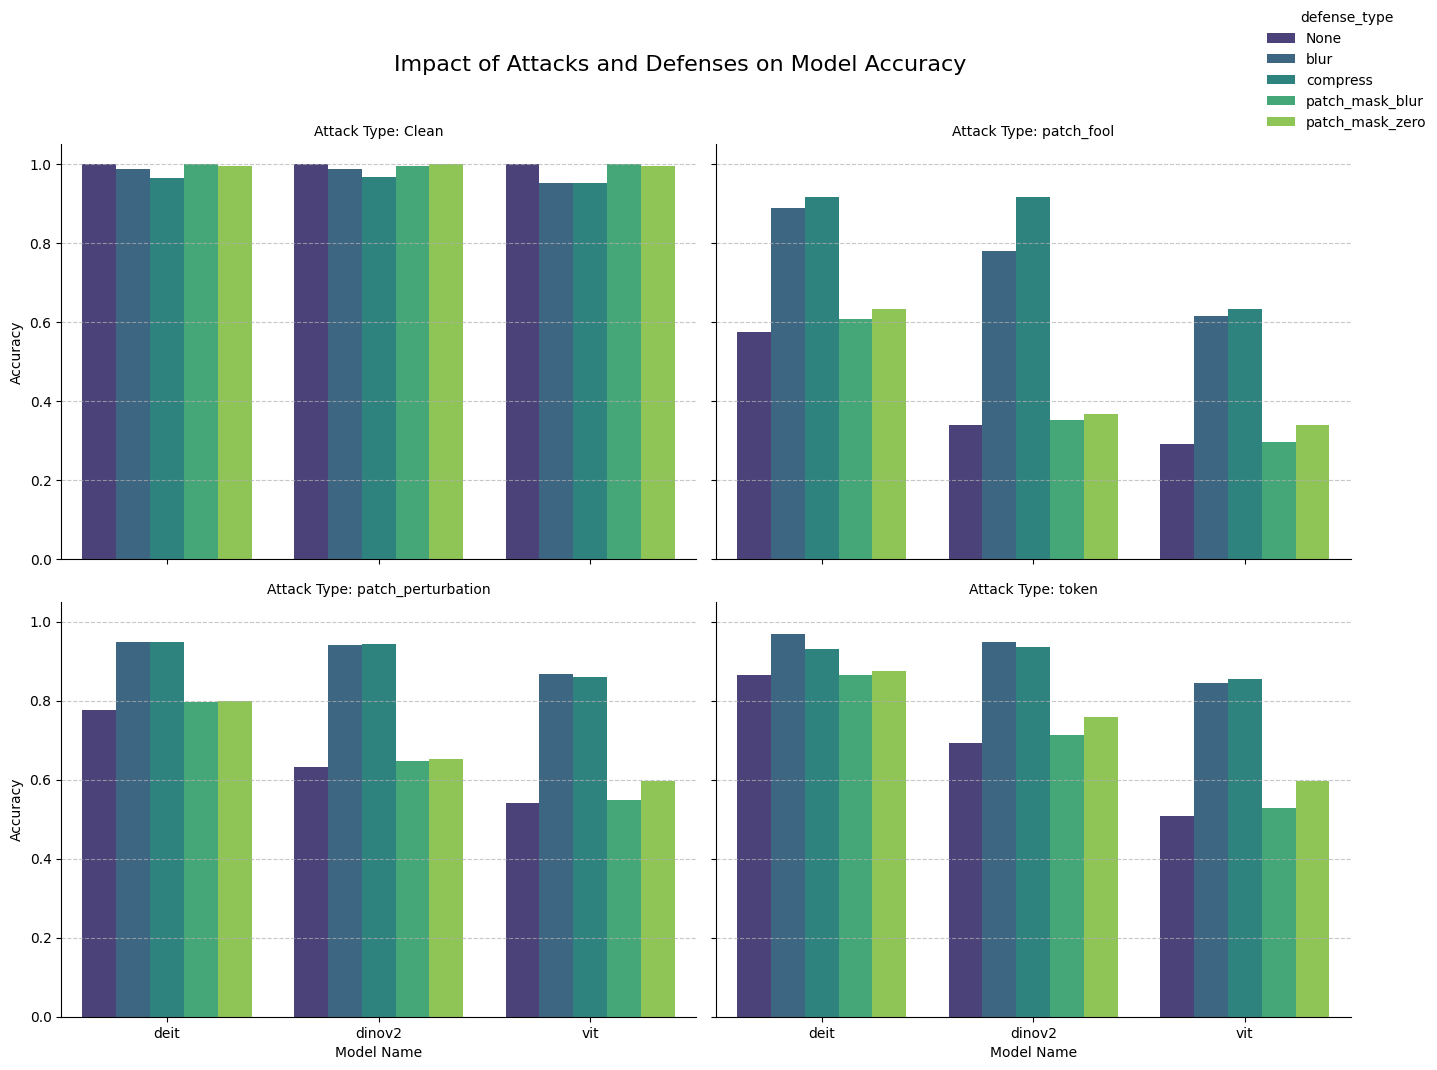

Clustered bar chart showing the impact of attacks and defenses on model accuracy has been generated.


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a clustered bar chart using sns.catplot
g = sns.catplot(
    data=final_summary_df,
    x='model_name',
    y='accuracy',
    hue='defense_type',
    col='attack_type',
    kind='bar',
    col_wrap=2, # Wrap columns after 2 plots for better layout
    height=5, # Height of each facet
    aspect=1.2, # Aspect ratio of each facet
    palette='viridis' # Color palette
)

# Set titles and labels
g.set_axis_labels("Model Name", "Accuracy")
g.set_titles("Attack Type: {col_name}")
g.fig.suptitle('Impact of Attacks and Defenses on Model Accuracy', y=1.02, fontsize=16) # Main title

# Set y-axis limit for better visualization of accuracy
plt.ylim(0, 1.05)

# Move legend to top right outside
g._legend.set_bbox_to_anchor((1.05, 1))

# Add grid for readability
for ax in g.axes.flat:
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

print("Clustered bar chart showing the impact of attacks and defenses on model accuracy has been generated.")

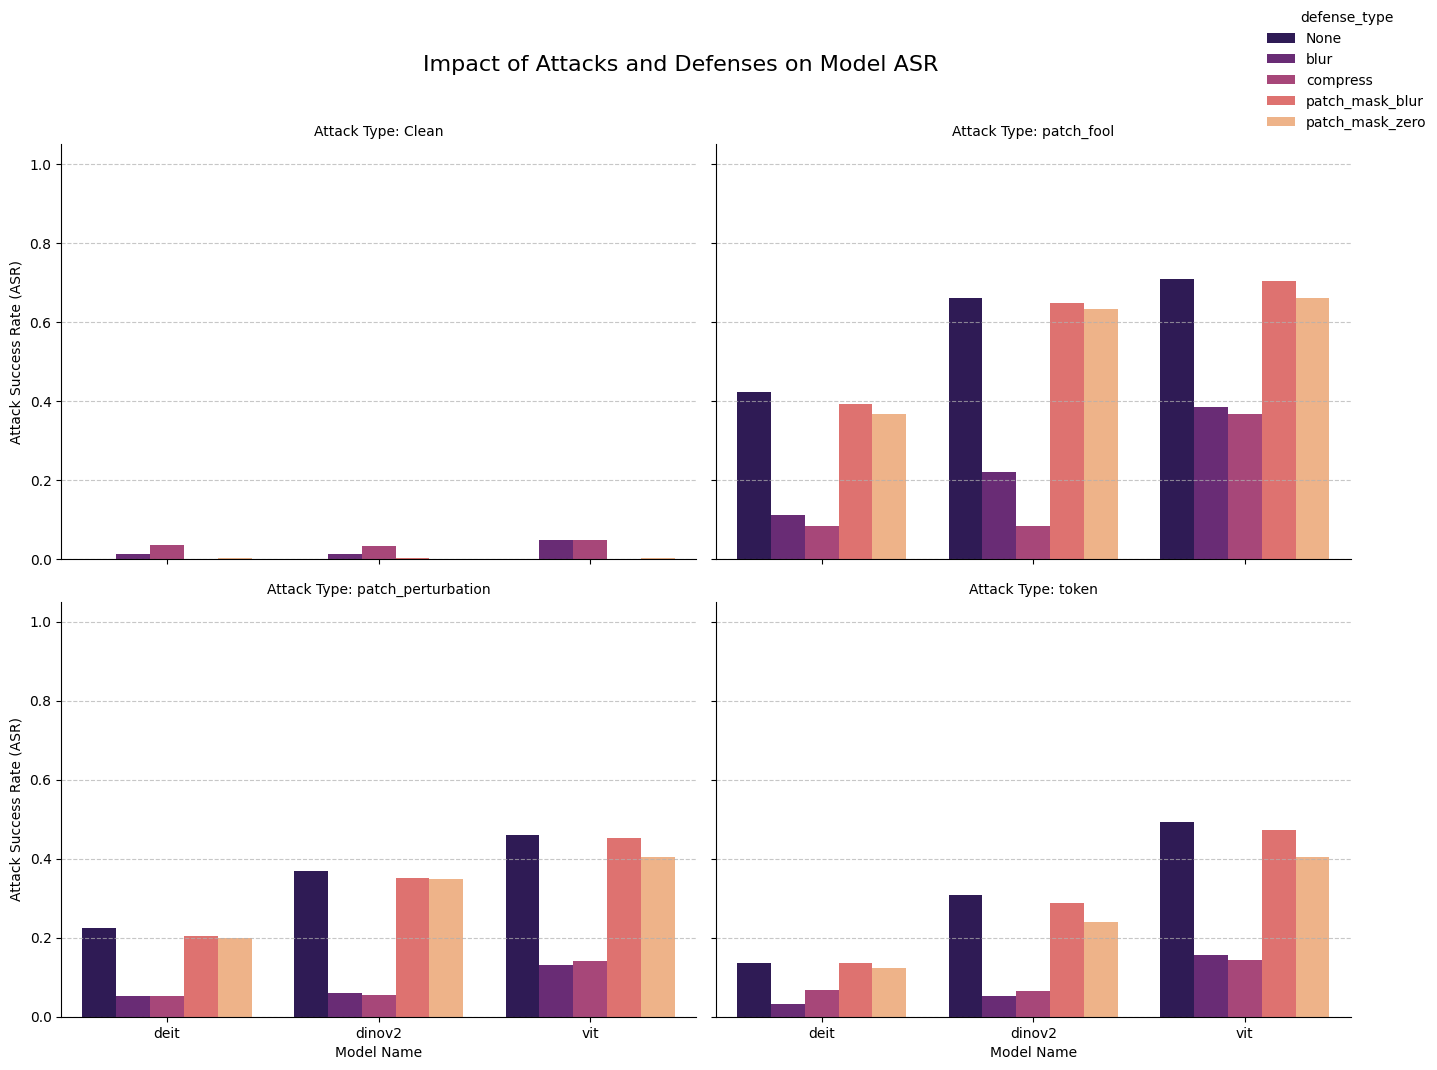

Clustered bar chart showing the impact of attacks and defenses on model ASR has been generated.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a clustered bar chart using sns.catplot for ASR
g = sns.catplot(
    data=final_summary_df,
    x='model_name',
    y='asr',
    hue='defense_type',
    col='attack_type',
    kind='bar',
    col_wrap=2, # Wrap columns after 2 plots for better layout
    height=5, # Height of each facet
    aspect=1.2, # Aspect ratio of each facet
    palette='magma' # Different color palette for contrast
)

# Set titles and labels
g.set_axis_labels("Model Name", "Attack Success Rate (ASR)")
g.set_titles("Attack Type: {col_name}")
g.fig.suptitle('Impact of Attacks and Defenses on Model ASR', y=1.02, fontsize=16) # Main title

# Set y-axis limit for better visualization of ASR
plt.ylim(0, 1.05)

# Move legend to top right outside
g._legend.set_bbox_to_anchor((1.05, 1))

# Add grid for readability
for ax in g.axes.flat:
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

print("Clustered bar chart showing the impact of attacks and defenses on model ASR has been generated.")